In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGiNG")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'
strategy.ret.loc['2013-01-02'] = strategy.ret.loc['2013-01-03']

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-30 20:29:17,891 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:29:17,894 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:29:17,894 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

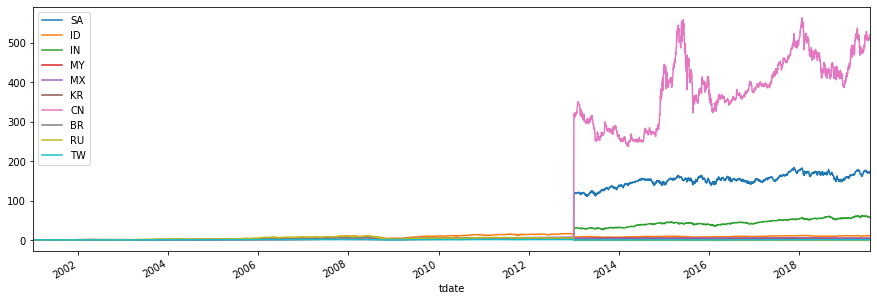

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

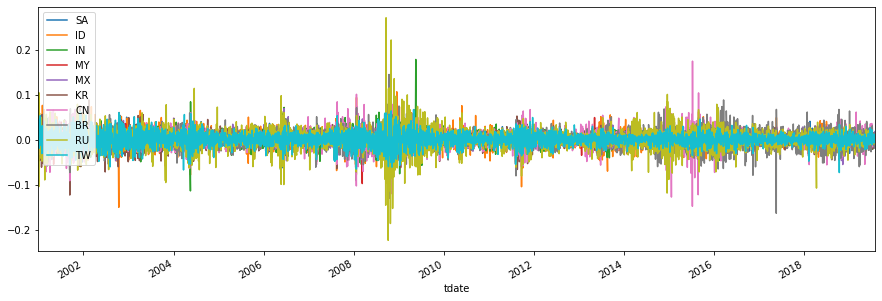

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### average return

In [10]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [11]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [12]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [13]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# CASE 0. 기존

<img src="./result/EMPM_PAST.png">

<img src="./result/EMPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [19]:
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

### binary - 50%

In [20]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [21]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [22]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [23]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [24]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.6914	valid_1's binary_logloss: 0.6914
[20]	training's binary_logloss: 0.689791	valid_1's binary_logloss: 0.689791
[30]	training's binary_logloss: 0.688525	valid_1's binary_logloss: 0.688525
[40]	training's binary_logloss: 0.687293	valid_1's binary_logloss: 0.687293
[50]	training's binary_logloss: 0.68609	valid_1's binary_logloss: 0.68609
[60]	training's binary_logloss: 0.685047	valid_1's binary_logloss: 0.685047
[70]	training's binary_logloss: 0.684081	valid_1's binary_logloss: 0.684081
[80]	training's binary_logloss: 0.682973	valid_1's binary_logloss: 0.682973
[90]	training's binary_logloss: 0.682081	valid_1's binary_logloss: 0.682081
[100]	training's binary_logloss: 0.681117	valid_1's binary_logloss: 0.681117
[110]	training's binary_logloss: 0.680226	valid_1's binary_logloss: 0.680226
[120]	training's binary_logloss: 0.679422	valid_1's binary_logloss: 0.679422
[130]	training's binary_loglo

In [25]:
test_pred = model.predict(df_test_x.values)

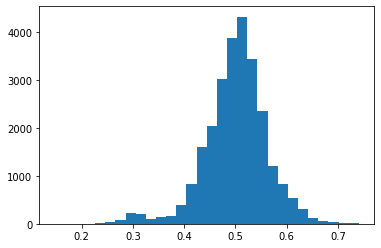

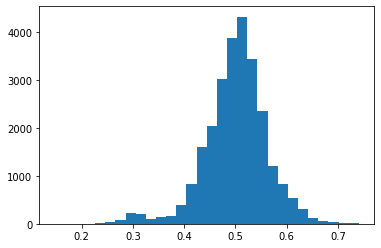

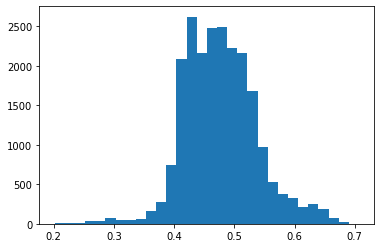

In [26]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [27]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [29]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [30]:
df_index_sub = df_index.loc['1994':]

In [31]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [32]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [33]:
strategy.set_rebalance_period(freq='month', rebalance_weekday=1) 

2019-10-30 20:29:31,379 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [34]:
tester = Tester(strategy)

In [35]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [36]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-30 20:29:32,555 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:29:32,556 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:29:32,557 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:29:39,411 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:29:39,412 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:29:41,051 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 20:29:41,057 - EMPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-30 20:29:42,052 - EMPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-30 20:29:42,055 - EMPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-30 20:29:42,055 - EMPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-30 20:29:42,056 - EMPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-30 20:29:44,674 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITIO

### TRAIN

2019-10-30 20:29:45,842 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:29:45,843 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:29:45,849 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:29:45,855 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


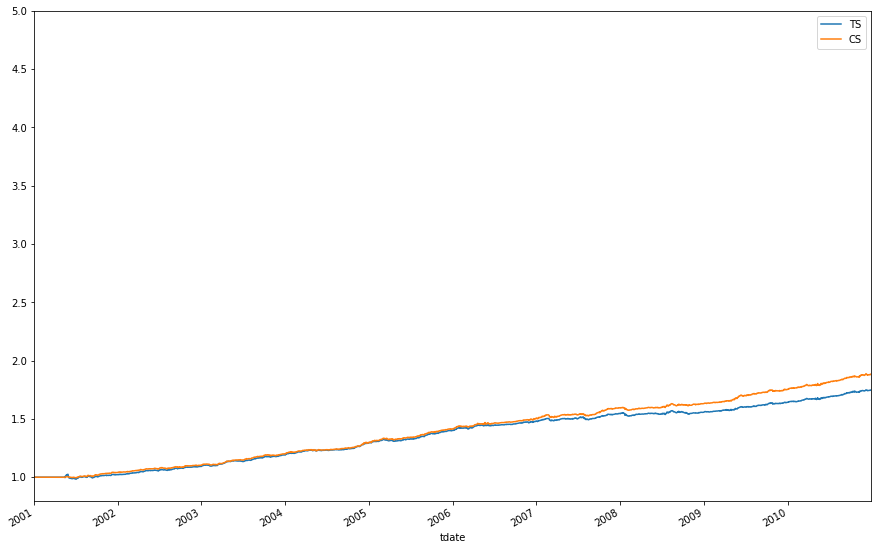

In [37]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 20:31:45,729 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:45,729 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:45,729 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:45,729 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:45,732 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:45,732 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:45,732 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:45,732 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:45,739 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:45,739 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:45,739 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:45,739 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:45,745 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:31:45,745 - 

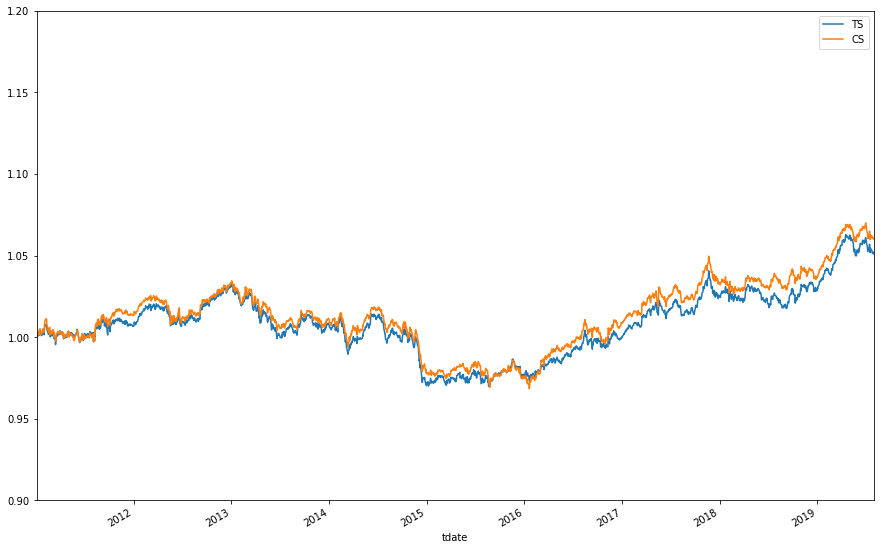

In [79]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [44]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [45]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [46]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [47]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [48]:
df_join2 = pd.merge(df_y2, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

In [49]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [50]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670688	valid_1's binary_logloss: 0.670688
[20]	training's binary_logloss: 0.668698	valid_1's binary_logloss: 0.668698
[30]	training's binary_logloss: 0.666664	valid_1's binary_logloss: 0.666664
[40]	training's binary_logloss: 0.664832	valid_1's binary_logloss: 0.664832
[50]	training's binary_logloss: 0.663085	valid_1's binary_logloss: 0.663085
[60]	training's binary_logloss: 0.661264	valid_1's binary_logloss: 0.661264
[70]	training's binary_logloss: 0.659516	valid_1's binary_logloss: 0.659516
[80]	training's binary_logloss: 0.657896	valid_1's binary_logloss: 0.657896
[90]	training's binary_logloss: 0.656181	valid_1's binary_logloss: 0.656181
[100]	training's binary_logloss: 0.654539	valid_1's binary_logloss: 0.654539
[110]	training's binary_logloss: 0.652972	valid_1's binary_logloss: 0.652972
[120]	training's binary_logloss: 0.651516	valid_1's binary_logloss: 0.651516
[130]	training's binary

In [51]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 1.100e+01, 2.900e+01, 2.400e+01, 3.000e+01, 6.200e+01,
        1.100e+02, 1.690e+02, 1.530e+02, 1.920e+02, 2.740e+02, 4.020e+02,
        7.960e+02, 1.122e+03, 2.150e+03, 2.712e+03, 3.379e+03, 4.596e+03,
        5.573e+03, 4.879e+03, 5.686e+03, 5.324e+03, 4.162e+03, 2.828e+03,
        1.848e+03, 1.129e+03, 5.390e+02, 9.800e+01, 6.500e+01, 2.300e+01]),
 array([0.11459434, 0.13842049, 0.16224664, 0.18607279, 0.20989894,
        0.23372509, 0.25755124, 0.2813774 , 0.30520355, 0.3290297 ,
        0.35285585, 0.376682  , 0.40050815, 0.4243343 , 0.44816045,
        0.4719866 , 0.49581276, 0.51963891, 0.54346506, 0.56729121,
        0.59111736, 0.61494351, 0.63876966, 0.66259581, 0.68642197,
        0.71024812, 0.73407427, 0.75790042, 0.78172657, 0.80555272,
        0.82937887]),
 <a list of 30 Patch objects>)

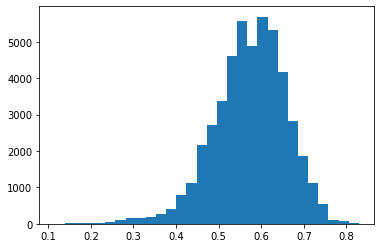

In [52]:
plt.hist(pred2, bins=30)

In [53]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [54]:
strategy2 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'
strategy2.ret.loc['2013-01-02'] = strategy2.ret.loc['2013-01-03']


strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 20:30:13,347 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:13,347 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:13,348 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:13,348 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:13,349 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:13,349 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [55]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-30 20:30:14,356 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:14,356 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:14,357 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:14,357 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:14,358 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:14,358 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:14,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:14,359 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:21,138 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:30:21,138 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:30:21,139 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:30:21,139 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 20:30:22,810 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 20:30:22

### TRAIN

2019-10-30 20:30:27,667 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:30:27,667 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:30:27,669 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:30:27,669 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:30:27,676 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:30:27,676 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:30:27,682 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:30:27,682 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


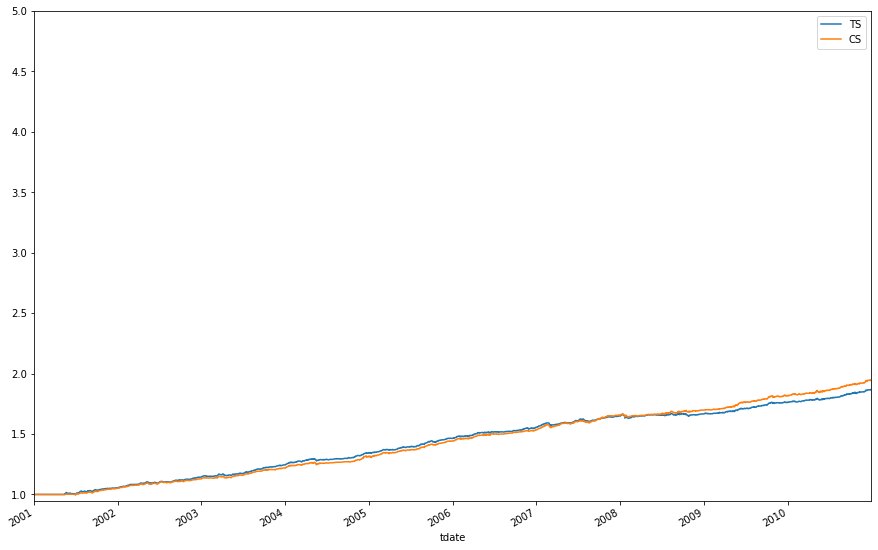

In [56]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 20:31:39,098 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:39,098 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:39,098 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:39,098 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:39,100 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:39,100 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:39,100 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:39,100 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:39,107 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:39,107 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:39,107 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:39,107 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:39,113 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:31:39,113 - 

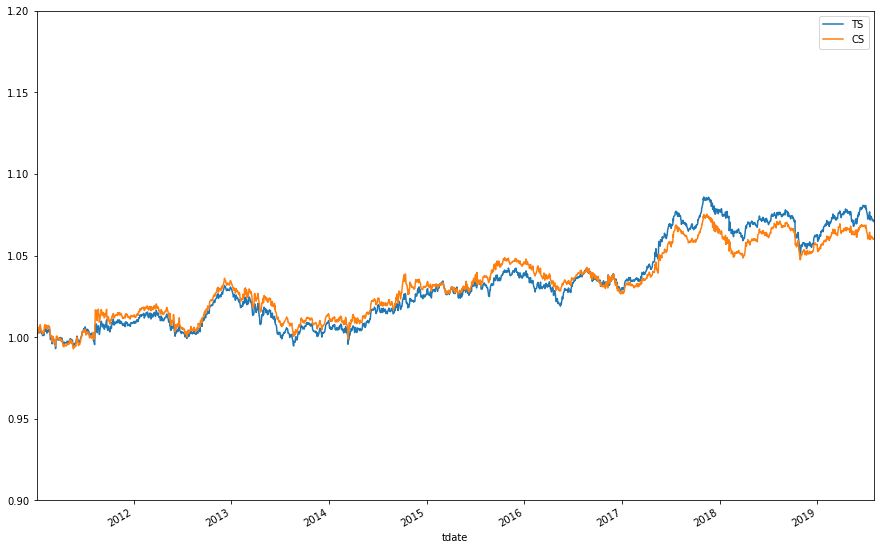

In [78]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [58]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [59]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.6914	valid_1's binary_logloss: 0.693175
[20]	training's binary_logloss: 0.689791	valid_1's binary_logloss: 0.692735
[30]	training's binary_logloss: 0.688525	valid_1's binary_logloss: 0.692778
[40]	training's binary_logloss: 0.687293	valid_1's binary_logloss: 0.692784
[50]	training's binary_logloss: 0.68609	valid_1's binary_logloss: 0.692636
[60]	training's binary_logloss: 0.685047	valid_1's binary_logloss: 0.692863
[70]	training's binary_logloss: 0.684081	valid_1's binary_logloss: 0.692851
[80]	training's binary_logloss: 0.682973	valid_1's binary_logloss: 0.693343
[90]	training's binary_logloss: 0.682081	valid_1's binary_logloss: 0.693428
[100]	training's binary_logloss: 0.681117	valid_1's binary_logloss: 0.693462
[110]	training's binary_logloss: 0.680226	valid_1's binary_logloss: 0.693852
[120]	training's binary_logloss: 0.679422	valid_1's binary_logloss: 0.694163
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[60]	training's binary_logloss: 0.685293	valid_1's binary_logloss: 0.693314
[70]	training's binary_logloss: 0.684337	valid_1's binary_logloss: 0.693101
[80]	training's binary_logloss: 0.683447	valid_1's binary_logloss: 0.693257
[90]	training's binary_logloss: 0.68253	valid_1's binary_logloss: 0.693297
[100]	training's binary_logloss: 0.681716	valid_1's binary_logloss: 0.693221
[110]	training's binary_logloss: 0.680907	valid_1's binary_logloss: 0.693494
[120]	training's binary_logloss: 0.680154	valid_1's binary_logloss: 0.693554
[130]	training's binary_logloss: 0.679403	valid_1's binary_logloss: 0.693675
[140]	training's binary_logloss: 0.678619	valid_1's binary_logloss: 0.693673
[150]	training's binary_logloss: 0.677958	valid_1's binary_logloss: 0.693541
[160]	training's binary_logloss: 0.677361	valid_1's binary_logloss: 0.693422
[170]	training's binary_logloss: 0.676674	valid_1's binary_logloss: 0.693013
[180]	training's binary_logloss: 0.676011	valid_1's binary_logloss: 0.692649
[19

[220]	training's binary_logloss: 0.678669	valid_1's binary_logloss: 0.688388
[230]	training's binary_logloss: 0.678201	valid_1's binary_logloss: 0.687939
[240]	training's binary_logloss: 0.677683	valid_1's binary_logloss: 0.687606
[250]	training's binary_logloss: 0.67723	valid_1's binary_logloss: 0.687557
[260]	training's binary_logloss: 0.67679	valid_1's binary_logloss: 0.687141
[270]	training's binary_logloss: 0.676373	valid_1's binary_logloss: 0.68713
[280]	training's binary_logloss: 0.675955	valid_1's binary_logloss: 0.687037
[290]	training's binary_logloss: 0.675508	valid_1's binary_logloss: 0.686977
[300]	training's binary_logloss: 0.675055	valid_1's binary_logloss: 0.686683
[310]	training's binary_logloss: 0.674618	valid_1's binary_logloss: 0.686671
[320]	training's binary_logloss: 0.67413	valid_1's binary_logloss: 0.686514
[330]	training's binary_logloss: 0.673723	valid_1's binary_logloss: 0.686552
[340]	training's binary_logloss: 0.673322	valid_1's binary_logloss: 0.686145
[35

[380]	training's binary_logloss: 0.673712	valid_1's binary_logloss: 0.69803
[390]	training's binary_logloss: 0.673271	valid_1's binary_logloss: 0.698452
[400]	training's binary_logloss: 0.67284	valid_1's binary_logloss: 0.698788
[410]	training's binary_logloss: 0.672379	valid_1's binary_logloss: 0.698848
[420]	training's binary_logloss: 0.672006	valid_1's binary_logloss: 0.699399
[430]	training's binary_logloss: 0.671591	valid_1's binary_logloss: 0.700204
[440]	training's binary_logloss: 0.671187	valid_1's binary_logloss: 0.700397
[450]	training's binary_logloss: 0.670797	valid_1's binary_logloss: 0.700651
[460]	training's binary_logloss: 0.670426	valid_1's binary_logloss: 0.700818
[470]	training's binary_logloss: 0.669967	valid_1's binary_logloss: 0.701644
[480]	training's binary_logloss: 0.669582	valid_1's binary_logloss: 0.702061
[490]	training's binary_logloss: 0.669205	valid_1's binary_logloss: 0.702166
[500]	training's binary_logloss: 0.668842	valid_1's binary_logloss: 0.702158
D

[410]	training's binary_logloss: 0.673345	valid_1's binary_logloss: 0.702768
[420]	training's binary_logloss: 0.67301	valid_1's binary_logloss: 0.702811
[430]	training's binary_logloss: 0.672633	valid_1's binary_logloss: 0.70425
[440]	training's binary_logloss: 0.672228	valid_1's binary_logloss: 0.705901
[450]	training's binary_logloss: 0.671876	valid_1's binary_logloss: 0.706759
[460]	training's binary_logloss: 0.671496	valid_1's binary_logloss: 0.707476
[470]	training's binary_logloss: 0.671137	valid_1's binary_logloss: 0.708351
[480]	training's binary_logloss: 0.670693	valid_1's binary_logloss: 0.709486
[490]	training's binary_logloss: 0.670418	valid_1's binary_logloss: 0.709522
[500]	training's binary_logloss: 0.670042	valid_1's binary_logloss: 0.710247
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.670042	valid_1's binary_logloss: 0.710247
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692339	vali

In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([2.100e+01, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 7.000e+00,
        1.600e+01, 2.300e+01, 8.100e+01, 1.400e+02, 3.120e+02, 5.450e+02,
        5.410e+02, 1.212e+03, 1.495e+03, 2.663e+03, 3.401e+03, 3.676e+03,
        1.941e+03, 1.813e+03, 9.180e+02, 9.340e+02, 1.000e+03, 6.750e+02,
        3.980e+02, 2.550e+02, 1.500e+02, 5.600e+01, 4.000e+01, 2.400e+01]),
 array([0.13824988, 0.15893803, 0.17962618, 0.20031433, 0.22100249,
        0.24169064, 0.26237879, 0.28306694, 0.30375509, 0.32444325,
        0.3451314 , 0.36581955, 0.3865077 , 0.40719585, 0.427884  ,
        0.44857216, 0.46926031, 0.48994846, 0.51063661, 0.53132476,
        0.55201292, 0.57270107, 0.59338922, 0.61407737, 0.63476552,
        0.65545367, 0.67614183, 0.69682998, 0.71751813, 0.73820628,
        0.75889443]),
 <a list of 30 Patch objects>)

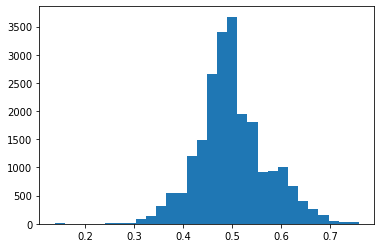

In [63]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [64]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [65]:
strategy3 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'
strategy3.ret.loc['2013-01-02'] = strategy3.ret.loc['2013-01-03']


strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 20:30:33,959 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:33,959 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:33,959 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:33,960 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:33,960 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:33,960 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:33,961 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:33,961 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:33,961 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [66]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-30 20:30:33,992 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:33,992 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:33,992 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:33,993 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:33,993 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:33,993 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:33,995 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:33,995 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:33,995 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:33,996 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:33,996 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:33,996 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:40,846 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:30:40,846 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 20:30:

2019-10-30 20:31:32,506 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:32,506 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:32,506 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:32,506 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:32,508 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:32,508 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:32,508 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:32,508 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:32,515 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:32,515 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:32,515 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:32,515 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:32,522 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:31:32,522 - 

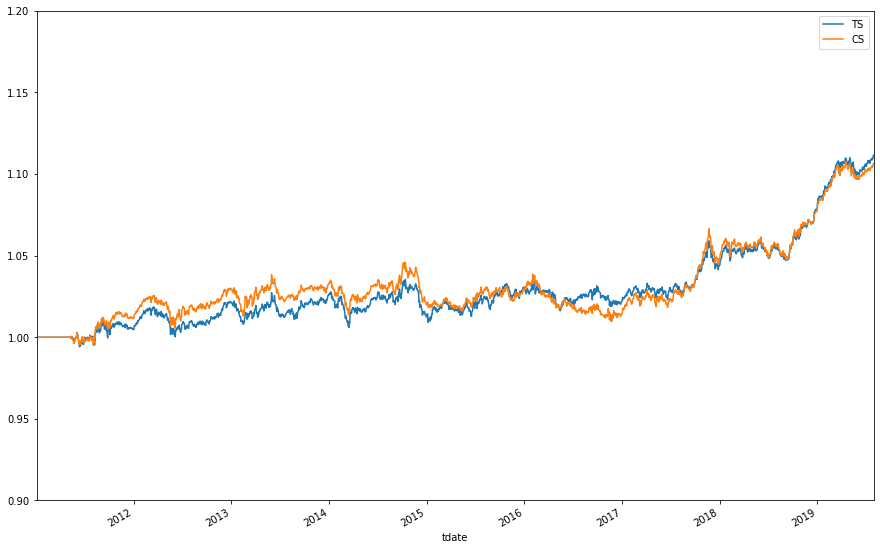

In [77]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [68]:
models = []
train_preds = []
test_preds = []

In [69]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670688	valid_1's binary_logloss: 0.71354
[20]	training's binary_logloss: 0.668698	valid_1's binary_logloss: 0.712776
[30]	training's binary_logloss: 0.666664	valid_1's binary_logloss: 0.711849
[40]	training's binary_logloss: 0.664832	valid_1's binary_logloss: 0.710241
[50]	training's binary_logloss: 0.663085	valid_1's binary_logloss: 0.707678
[60]	training's binary_logloss: 0.661264	valid_1's binary_logloss: 0.70619
[70]	training's binary_logloss: 0.659516	valid_1's binary_logloss: 0.705849
[80]	training's binary_logloss: 0.657896	valid_1's binary_logloss: 0.705595
[90]	training's binary_logloss: 0.656181	valid_1's binary_logloss: 0.70563
[100]	training's binary_logloss: 0.654539	valid_1's binary_logloss: 0.705518
[110]	training's binary_logloss: 0.652972	valid_1's binary_logloss: 0.70706
[120]	training's binary_logloss: 0.651516	valid_1's binary_logloss: 0.707263
[130]	training's binary_log

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.671096	valid_1's binary_logloss: 0.712527
[20]	training's binary_logloss: 0.669372	valid_1's binary_logloss: 0.711625
[30]	training's binary_logloss: 0.667676	valid_1's binary_logloss: 0.71042
[40]	training's binary_logloss: 0.665975	valid_1's binary_logloss: 0.709663
[50]	training's binary_logloss: 0.664313	valid_1's binary_logloss: 0.709867
[60]	training's binary_logloss: 0.662542	valid_1's binary_logloss: 0.708907
[70]	training's binary_logloss: 0.660716	valid_1's binary_logloss: 0.708831
[80]	training's binary_logloss: 0.659096	valid_1's binary_logloss: 0.708375
[90]	training's binary_logloss: 0.657466	valid_1's binary_logloss: 0.708156
[100]	training's binary_logloss: 0.655902	valid_1's binary_logloss: 0.708009
[110]	training's binary_logloss: 0.654302	valid_1's binary_logloss: 0.708097
[120]	training's binary_logloss: 0.652827	valid_1's binary_logloss: 0.708006
[130]	training's binary_

[310]	training's binary_logloss: 0.635435	valid_1's binary_logloss: 0.739849
[320]	training's binary_logloss: 0.634536	valid_1's binary_logloss: 0.73698
[330]	training's binary_logloss: 0.633667	valid_1's binary_logloss: 0.739753
[340]	training's binary_logloss: 0.632741	valid_1's binary_logloss: 0.740081
[350]	training's binary_logloss: 0.631932	valid_1's binary_logloss: 0.740061
[360]	training's binary_logloss: 0.631051	valid_1's binary_logloss: 0.740645
[370]	training's binary_logloss: 0.630132	valid_1's binary_logloss: 0.740384
[380]	training's binary_logloss: 0.629341	valid_1's binary_logloss: 0.741779
[390]	training's binary_logloss: 0.628442	valid_1's binary_logloss: 0.741469
[400]	training's binary_logloss: 0.627549	valid_1's binary_logloss: 0.744286
[410]	training's binary_logloss: 0.626743	valid_1's binary_logloss: 0.74748
[420]	training's binary_logloss: 0.625908	valid_1's binary_logloss: 0.752415
[430]	training's binary_logloss: 0.625078	valid_1's binary_logloss: 0.754021
[

[480]	training's binary_logloss: 0.622992	valid_1's binary_logloss: 0.720645
[490]	training's binary_logloss: 0.622336	valid_1's binary_logloss: 0.719475
[500]	training's binary_logloss: 0.621589	valid_1's binary_logloss: 0.718589
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.621589	valid_1's binary_logloss: 0.718589
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.671333	valid_1's binary_logloss: 0.711701
[20]	training's binary_logloss: 0.669887	valid_1's binary_logloss: 0.710365
[30]	training's binary_logloss: 0.66834	valid_1's binary_logloss: 0.70899
[40]	training's binary_logloss: 0.666986	valid_1's binary_logloss: 0.707749
[50]	training's binary_logloss: 0.665747	valid_1's binary_logloss: 0.707431
[60]	training's binary_logloss: 0.664567	valid_1's binary_logloss: 0.706399
[70]	training's binary_logloss: 0.663461	valid_1's binary_logloss: 0.705209
[80]	training's binary_logloss: 0.662343	valid_1's b

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.67176	valid_1's binary_logloss: 0.741766
[20]	training's binary_logloss: 0.670644	valid_1's binary_logloss: 0.743428
[30]	training's binary_logloss: 0.669545	valid_1's binary_logloss: 0.744271
[40]	training's binary_logloss: 0.668485	valid_1's binary_logloss: 0.74513
[50]	training's binary_logloss: 0.667267	valid_1's binary_logloss: 0.745106
[60]	training's binary_logloss: 0.665895	valid_1's binary_logloss: 0.745093
[70]	training's binary_logloss: 0.664739	valid_1's binary_logloss: 0.743312
[80]	training's binary_logloss: 0.663527	valid_1's binary_logloss: 0.742562
[90]	training's binary_logloss: 0.662477	valid_1's binary_logloss: 0.740847
[100]	training's binary_logloss: 0.661434	valid_1's binary_logloss: 0.739817
[110]	training's binary_logloss: 0.66044	valid_1's binary_logloss: 0.73952
[120]	training's binary_logloss: 0.659502	valid_1's binary_logloss: 0.738082
[130]	training's binary_log

In [70]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [71]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [72]:
strategy4 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'
strategy4.ret.loc['2013-01-02'] = strategy4.ret.loc['2013-01-03']


strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 20:30:48,467 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:48,467 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:48,467 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:48,467 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-30 20:30:48,469 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:48,469 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:48,469 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:48,469 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-30 20:30:48,471 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:48,471 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:48,471 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 20:30:48,471 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [73]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-30 20:30:48,506 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:48,506 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:48,506 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:48,506 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 20:30:48,507 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:48,507 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:48,507 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:48,507 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 20:30:48,509 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:48,509 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:48,509 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:48,509 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 20:30:48,510 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:48,510 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 20:30:48,510 

2019-10-30 20:31:25,138 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:25,138 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:25,138 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:25,138 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-30 20:31:25,140 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:25,140 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:25,140 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:25,140 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-30 20:31:25,147 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:25,147 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:25,147 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:25,147 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-30 20:31:25,153 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 20:31:25,153 - 

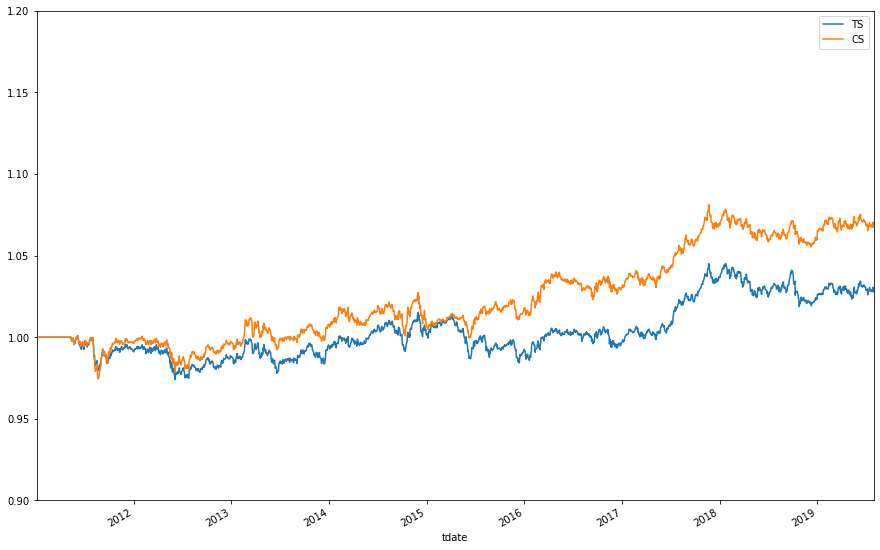

In [76]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))